In [20]:
import numpy as np
import jax
import jax.numpy as jnp

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/6w/2tdqp9m179gg5blnzww9hgjc0000gn/T/ipykernel_67639/2012753567.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [24]:
# Inputs
n_obs = 11

x_obs = np.zeros((n_obs, 3, n_t))
x_obs[:,0] = np.linspace(100, 6500, n_obs)
x_obs[:,2] = 4*0.3048*np.ones(n_obs)
x_obs = jnp.array(x_obs)

n_t = 101
x = jnp.linspace(0, 1000, n_t)
y = jnp.linspace(0, 10, n_t)
z = jnp.linspace(0, 100, n_t)
alpha = jnp.linspace(0, 10, n_t)
gamma = jnp.linspace(10, 20, n_t)
t_s = jnp.linspace(0, 100, n_t)
c_0 = 340. * jnp.ones(n_t,)
T_0 = 300. * jnp.ones(n_t,)

ValueError: could not broadcast input array from shape (11,) into shape (11,101)

In [3]:
# Geometry calculations
# Compute body angles (psi_B, theta_B, phi_B): angle of body w.r.t. horizontal
theta_B = alpha + gamma
phi_B = jnp.zeros(alpha.shape)
psi_B = jnp.zeros(alpha.shape)

# Compute the relative observer-source position vector i.e. difference between observer and ac coordinate
# Note: add 4 meters to the alitude of the aircraft (for engine height)
r_0 =  x_obs[:,0] - x
# r_1 =  x_obs[1] - y
# r_2 = -x_obs[2] + (z + 4)


ValueError: Incompatible shapes for broadcasting: shapes=[(101, 11, 3), (101,)]

In [47]:
def compute_geometry(x, y, z, alpha, gamma, t_s, c_0, T_0, x_obs):

    # Iterate over observers
    for i in np.arange(n_obs):

        # Geometry calculations
        # Compute body angles (psi_B, theta_B, phi_B): angle of body w.r.t. horizontal
        theta_B = alpha + gamma
        phi_B = np.zeros(alpha.shape)
        psi_B = np.zeros(alpha.shape)

        # Compute the relative observer-source position vector i.e. difference between observer and ac coordinate
        # Note: add 4 meters to the alitude of the aircraft (for engine height)
        r_0 =  settings['x_observer_array'][i,0] - x
        r_1 =  settings['x_observer_array'][i,1] - y
        r_2 = -settings['x_observer_array'][i,2] + (z + 4)

        # Compute the distance of the observer-source vector
        R = np.sqrt(r_0 ** 2 + r_1 ** 2 + r_2 ** 2)
        outputs['r'][i,:] = R

        # Normalize the distance vector
        # Source: Zorumski report 1982 part 1. Chapter 2.2 Equation 17
        n_vcr_a_0 = r_0 / R
        n_vcr_a_1 = r_1 / R
        n_vcr_a_2 = r_2 / R

        # Define elevation angle
        # Source: Zorumski report 1982 part 1. Chapter 2.2 Equation 21
        outputs['beta'][i,:] = 180. / np.pi * np.arcsin(n_vcr_a_2)

        # Transformation direction cosines (Euler angles) to the source coordinate system (i.e. take position of the aircraft into account)
        # Source: Zorumski report 1982 part 1. Chapter 2.2 Equation 22-25
        cth  = np.cos(np.pi / 180. * theta_B)
        sth  = np.sin(np.pi / 180. * theta_B)
        cphi = np.cos(np.pi / 180. * phi_B)
        sphi = np.sin(np.pi / 180. * phi_B)
        cpsi = np.cos(np.pi / 180. * psi_B)
        spsi = np.sin(np.pi / 180. * psi_B)

        n_vcr_s_0 = cth * cpsi * n_vcr_a_0 + cth * spsi * n_vcr_a_1 - sth * n_vcr_a_2
        n_vcr_s_1 = (-spsi * cphi + sphi * sth * cpsi) * n_vcr_a_0 + ( cphi * cpsi + sphi * sth * spsi) * n_vcr_a_1 + sphi * cth * n_vcr_a_2
        n_vcr_s_2 = (spsi * sphi + cphi * sth * cpsi) * n_vcr_a_0 + ( -sphi * cpsi + cphi * sth * spsi) * n_vcr_a_1 + cphi * cth * n_vcr_a_2

        # Compute polar directivity angle
        # Source: Zorumski report 1982 part 1. Chapter 2.2 Equation 26
        theta = 180. / np.pi * np.arccos(n_vcr_s_0)
        outputs['theta'][i,:] = theta

        # Compute azimuthal directivity angle
        # Source: Zorumski report 1982 part 1. Chapter 2.2 Equation 27
        phi = -180. / np.pi * np.arctan2(n_vcr_s_1, n_vcr_s_2)
        if settings['case_name'] in ["nasa_stca_standard", "stca_enginedesign_standard"]:
            outputs['phi'][i, :] = np.zeros(n_t)
        else:
            phi[phi==-180.] = np.zeros(n_t)[phi==-180.]
            outputs['phi'][i,:] = phi

        # Compute average speed of sound between source and observer
        n_intermediate = 11
        dz = z / n_intermediate
        c_bar = c_0
        for k in np.arange(1, n_intermediate):
            T_im = T_0 - k * dz * (-0.0065)
            c_im = np.sqrt(1.4 * 287. * T_im)
            c_bar = (k) / (k + 1) * c_bar + c_im / (k + 1)
        outputs['c_bar'][i,:] = c_bar

        # Compute observed time
        # Source: Zorumski report 1982 part 1. Chapter 2.2 Equation 20
        outputs['t_o'][i,:] = t_s + outputs['r'][i,:] / outputs['c_bar'][i,:]

    return 

In [54]:
compute_geometry(x, y, z, alpha, gamma, t_s, c_0, T_0, x_obs)

(DeviceArray([3528.811 , 3528.7117, 3528.6125, ..., 2540.702 , 2540.6038,
              2540.5054], dtype=float32),
 DeviceArray([12.411426, 12.413254, 12.415129, ..., 33.692154, 33.694454,
              33.696766], dtype=float32))

In [55]:
f_p = jax.jacfwd(compute_geometry, argnums=0)

%time J = f_p(x, y, z, alpha, gamma, t_s, c_0, T_0, x_obs)

J

CPU times: user 9.78 s, sys: 10.1 s, total: 19.9 s
Wall time: 8.7 s


(DeviceArray([[-0.9918354 , -0.        , -0.        , ..., -0.        ,
               -0.        , -0.        ],
              [-0.        , -0.99183506, -0.        , ..., -0.        ,
               -0.        , -0.        ],
              [-0.        , -0.        , -0.9918346 , ..., -0.        ,
               -0.        , -0.        ],
              ...,
              [-0.        , -0.        , -0.        , ..., -0.98405886,
               -0.        , -0.        ],
              [-0.        , -0.        , -0.        , ..., -0.        ,
               -0.9840574 , -0.        ],
              [-0.        , -0.        , -0.        , ..., -0.        ,
               -0.        , -0.9840562 ]], dtype=float32),
 DeviceArray([[ 0.00122017, -0.        , -0.        , ..., -0.        ,
               -0.        , -0.        ],
              [-0.        ,  0.00122013, -0.        , ..., -0.        ,
               -0.        , -0.        ],
              [-0.        , -0.        ,  0.00122008

In [56]:
%time jax.jvp(compute_geometry, (x, y, z, alpha, gamma, t_s, c_0, T_0, x_obs), (jnp.ones(nn), jnp.zeros(nn), jnp.zeros(nn), jnp.zeros(nn), jnp.zeros(nn), jnp.zeros(nn), jnp.zeros(nn), jnp.zeros(nn), jnp.zeros(3)))

CPU times: user 68.3 ms, sys: 4.73 ms, total: 73.1 ms
Wall time: 72.2 ms


((DeviceArray([3528.811 , 3528.7117, 3528.6125, ..., 2540.702 , 2540.6038,
               2540.5054], dtype=float32),
  DeviceArray([12.411426, 12.413254, 12.415129, ..., 33.692154, 33.694454,
               33.696766], dtype=float32)),
 (DeviceArray([-0.9918354 , -0.99183506, -0.9918346 , ..., -0.98405886,
               -0.9840574 , -0.9840562 ], dtype=float32),
  DeviceArray([0.00122017, 0.00122013, 0.00122008, ..., 0.0019226 ,
               0.0019228 , 0.00192298], dtype=float32)))

In [34]:
%time jnp.sin(x)

CPU times: user 38 µs, sys: 6 µs, total: 44 µs
Wall time: 49.1 µs


DeviceArray([ 0.        , -0.914945  ,  0.73850435,  0.31885597,
             -0.9958712 ,  0.48499522,  0.60442543, -0.97282773,
              0.18080507,  0.82687956], dtype=float32)

In [26]:
import matplotlib.pyplot as plt

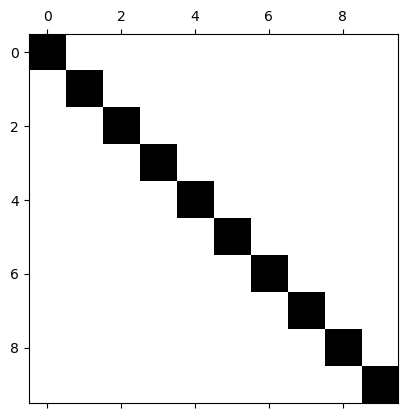

In [28]:
plt.spy(J)